In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
LAKES = ['EVINOS','MARATHONAS','MORNOS','YLIKI']
MEN = ['ASPROPYRGOS','GALATSI','KIOURKA','MENIDI']

In [3]:
# Import Dataset

data = pd.read_csv('data.csv',decimal='.')

In [4]:
# Take a sample -n- 
data = data.sample(n=2000)

In [5]:
data = data.replace(',','', regex=True)

In [6]:
data.iloc[:,1:11] = data.iloc[:,1:11].astype(str).astype(float)

In [7]:
data.iloc[:,2:11] = data.iloc[:,2:11].replace(',','', regex=True)

In [8]:
data.DATE = pd.to_datetime(data.DATE,dayfirst=True)

In [9]:
data.TIME = data.TIME.str.split(':')
data.TIME = data.TIME.str[0]

In [10]:
data['TIME.1'] = data['TIME.1'].str.split(':')
data['TIME.1'] = data['TIME.1'].str[0]

In [11]:
data['TIME.2'] = data['TIME.2'].str.split(':')
data['TIME.2'] = data['TIME.2'].str[0]

In [12]:
data['TIME'] = data['TIME'].astype(float)
data['TIME.1'] = data['TIME.1'].astype(float)
data['TIME.2'] = data['TIME.2'].astype(float)

In [13]:
pd.set_option('display.max_columns', None)

In [14]:
data = data.rename(columns = {'HIGH':'HIGH_TEMP',
                               'TIME':'HIGH_TEMP_TIME',
                               'TIME.1':'LOW_TEMP_TIME',
                               'SPEED':'WIND_SPEED',
                               'HIGH.1':'WIND_HIGH_SPEED',
                               'TIME.2':'WIND_HIGH_SPEED_TIME',
                               'DAYS':'HEAT_DEG_DAYS',
                             'DAYS.1':'COOL_DEG_DAYS',
                             'LOW':'LOW_TEMP'})

E:\Program Files\bootcamp\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


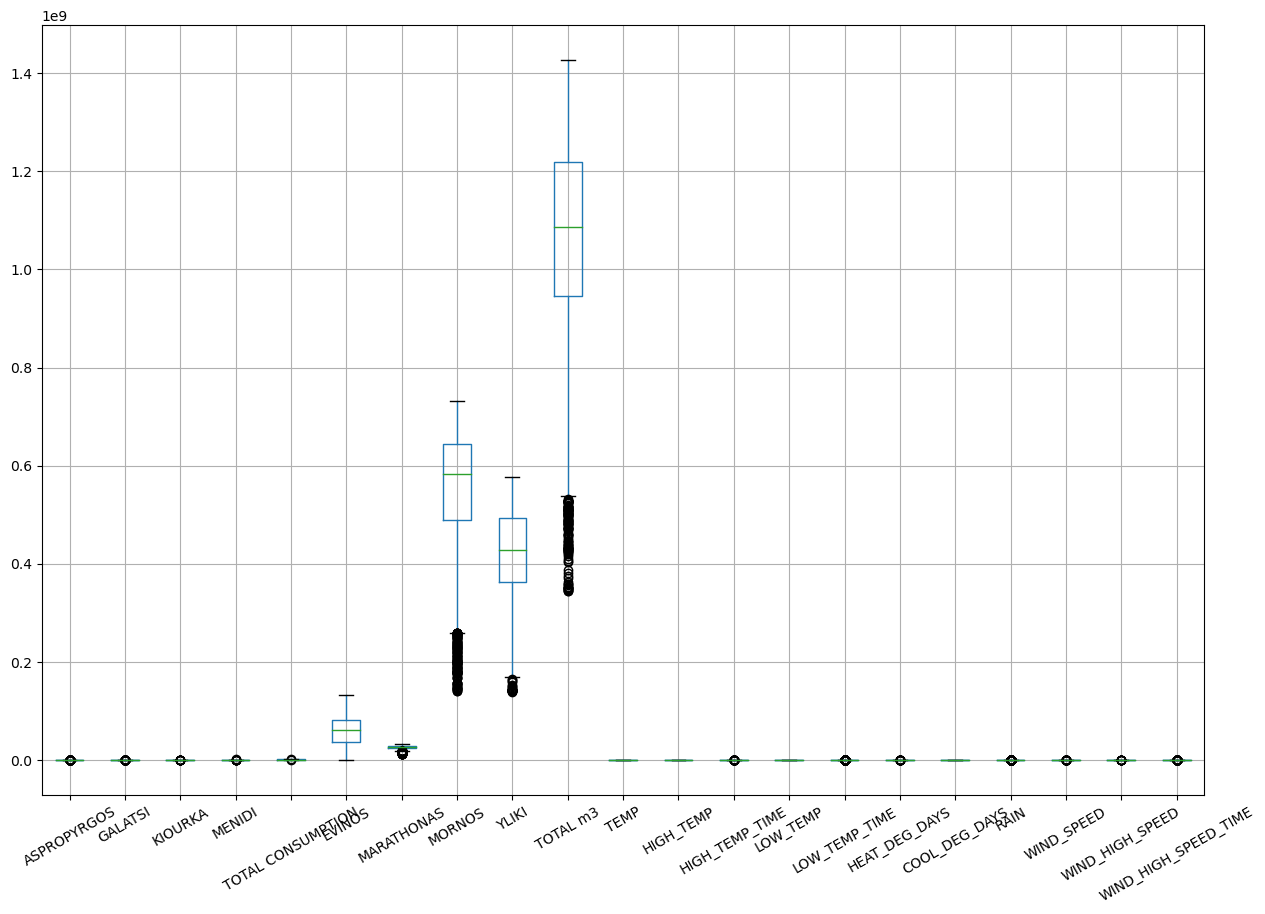

In [15]:
boxplot = data.boxplot(figsize=(15,10))
boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=30)
None

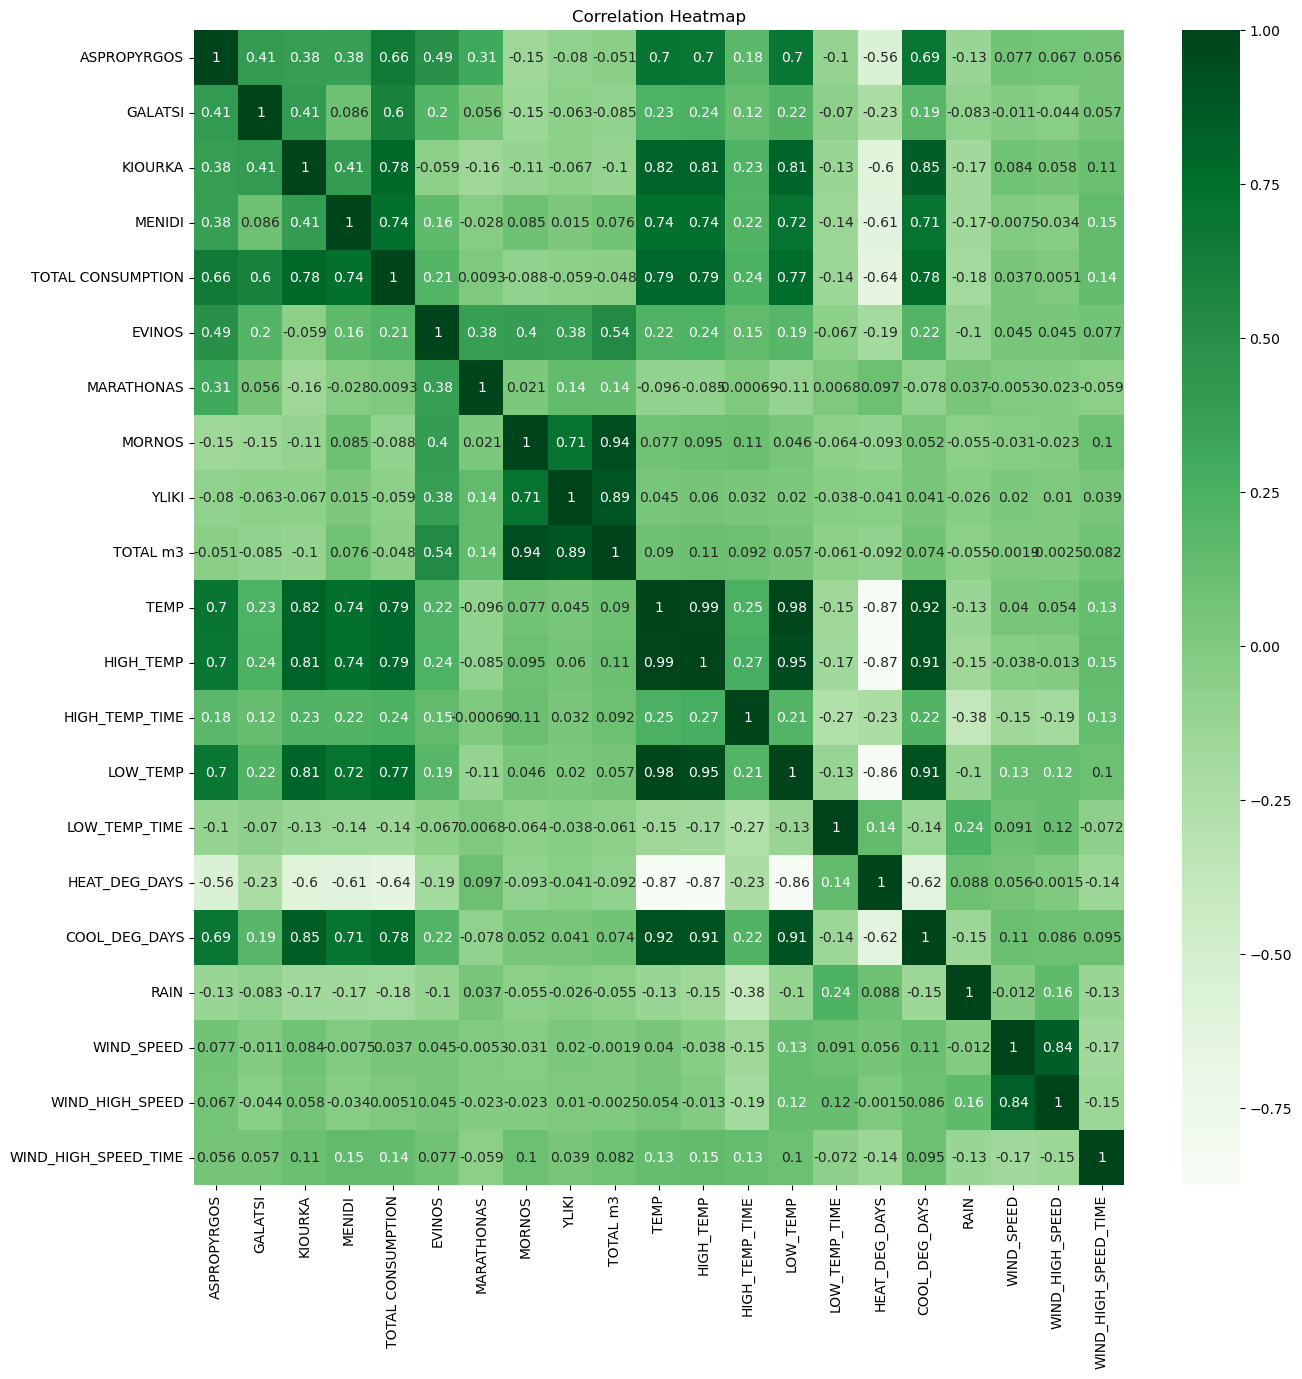

In [16]:
plt.figure(figsize = (15,15))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(data.corr(), annot = True, cmap="Greens")

In [17]:
# Delete features that have no correlation
DATA = data.loc[:, data.columns.drop(['TOTAL m3','WIND_HIGH_SPEED'])]
DATA.drop('WIND_SPEED',axis=1,inplace=True)
DATA.drop('WIND_HIGH_SPEED_TIME',axis=1,inplace=True)

In [18]:
# Delete features of MEN and LAKES. Lakes do not correlate with Attika Consumption. We drop out MEN as we have total consumption
DATA.drop(columns=MEN,inplace=True)
DATA.drop(columns=LAKES,inplace=True)

In [19]:
# Finally we drop NaNs
DATA = DATA.dropna()

In [20]:
print(f'Statistics for Rain: Min = {DATA.RAIN.min()} mm, Max = {DATA.RAIN.max()} mm, Median = {DATA.RAIN.median()} mm, Mean = {DATA.RAIN.mean()} mm')

Statistics for Rain: Min = 0.0 mm, Max = 97.0 mm, Median = 0.0 mm, Mean = 1.5197379197379197 mm


In [21]:
# Rain is not high correlated with Total consumption. To increase the correlation we create a new feature of RAIN.
# If RAIN is more than the median of rain, then 1 else 0. This increaces the correlation from -0.18 to -0.31.
RAIN_COND = DATA.RAIN.apply(lambda x: 1 if x>2*DATA.RAIN.median() else 0)

In [22]:
DATA['RAIN_COND'] = RAIN_COND.values

In [23]:
# RAIN feature is deleted eventually
DATA.drop('RAIN',axis=1,inplace=True)

In [24]:
# Time of low temperatures are not correlated. 
#DATA.drop('LOW_TEMP_TIME',axis=1,inplace=True)

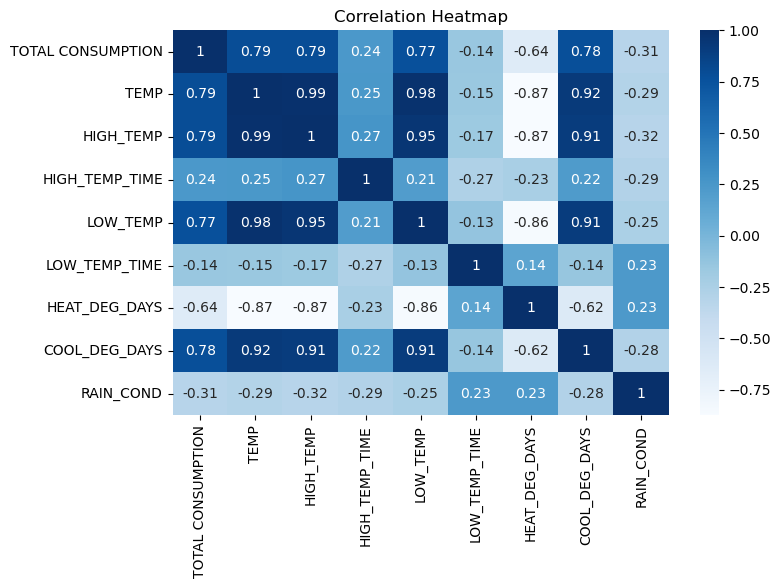

In [25]:
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA.corr(), annot = True, cmap="Blues")

In [26]:
# Insert a new file. "Savings and repos" vs Year and Month* --> dianeosis.gr
repos = pd.read_csv('chart_repos.csv')

In [27]:
# Below code is for joining DATA with the previous file
repos['Μήνας']=repos['Μήνας'].str.split(' ')

In [28]:
repos['Month'] = repos['Μήνας'].str[0]
repos['Year'] = repos['Μήνας'].str[1]

In [29]:
repos['Year'] = repos['Year'].astype(int)

In [30]:
repos.drop('Μήνας',axis=1,inplace=True)

In [31]:
m = {'Iανουάριος':1,
     'Ιανούαριος':1,
     'Ιανουάριος':1,
    'Φεβρουάριος':2,
    'Μάρτιος':3,
    'Απρίλιος':4,
    'Μάιος':5,
    'Ιούνιος':6,
    'Ιούλιος':7,
    'Αύγουστος':8,
    'Σεπτέμβριος':9,
    'Οκτώβριος':10,
    'Νοέμβριος':11,
    'Δεκέμβριος':12}

In [32]:
repos.replace({'Month':m},inplace=True)

In [33]:
DATA['Month'] = DATA['DATE'].dt.month
DATA['Year'] = DATA['DATE'].dt.year

In [34]:
DATA_2 = DATA.merge(repos, on=['Month', 'Year'], how='inner')

In [35]:
DATA_2.drop('Month',axis=1,inplace=True)
DATA_2.drop('Year',axis=1,inplace=True)

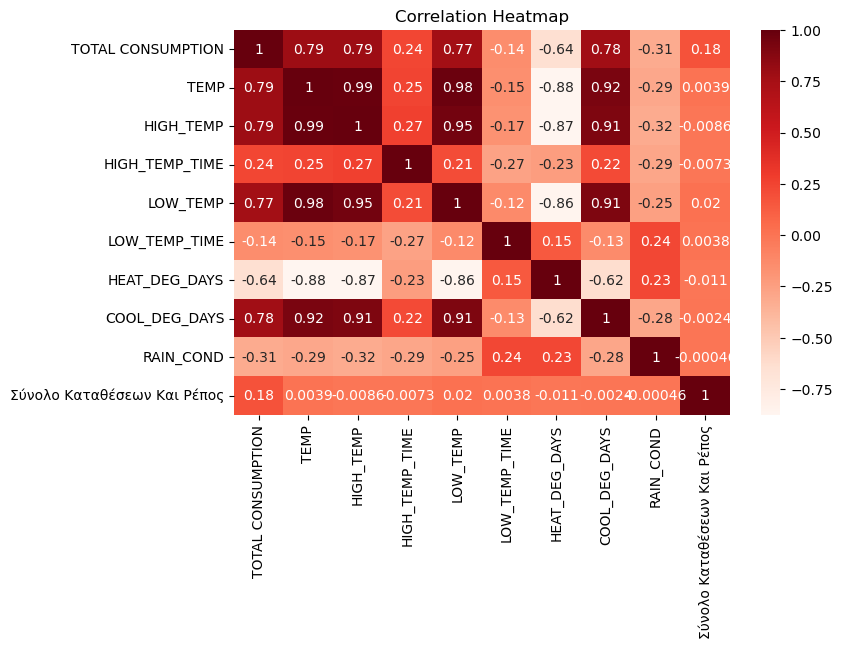

In [36]:
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_2.corr(), annot = True, cmap="Reds")

Savings and Repos have low correlation with consumption. This is because the water cost per m3 is low and the country is prosperous enough.

In [37]:
# Insert a new file. "Revised KPI of industrial production" vs Year and Month* --> dianeosis.gr
industrial_KPI = pd.read_csv('chart_industrial_KPI.csv')
industrial_KPI['Μήνας'] = industrial_KPI['Μήνας'].str.split(' ')
industrial_KPI['Month'] = industrial_KPI['Μήνας'].str[0]
industrial_KPI['Year'] = industrial_KPI['Μήνας'].str[1]
industrial_KPI['Year'] = industrial_KPI['Year'].astype(int)
industrial_KPI.drop('Μήνας',axis=1,inplace=True)
industrial_KPI.replace({'Month':m},inplace=True)

DATA_2['Month'] = DATA_2['DATE'].dt.month
DATA_2['Year'] = DATA_2['DATE'].dt.year
DATA_3 = DATA_2.merge(industrial_KPI, on=['Month', 'Year'], how='inner')
DATA_3.drop('Month',axis=1,inplace=True)
DATA_3.drop('Year',axis=1,inplace=True)

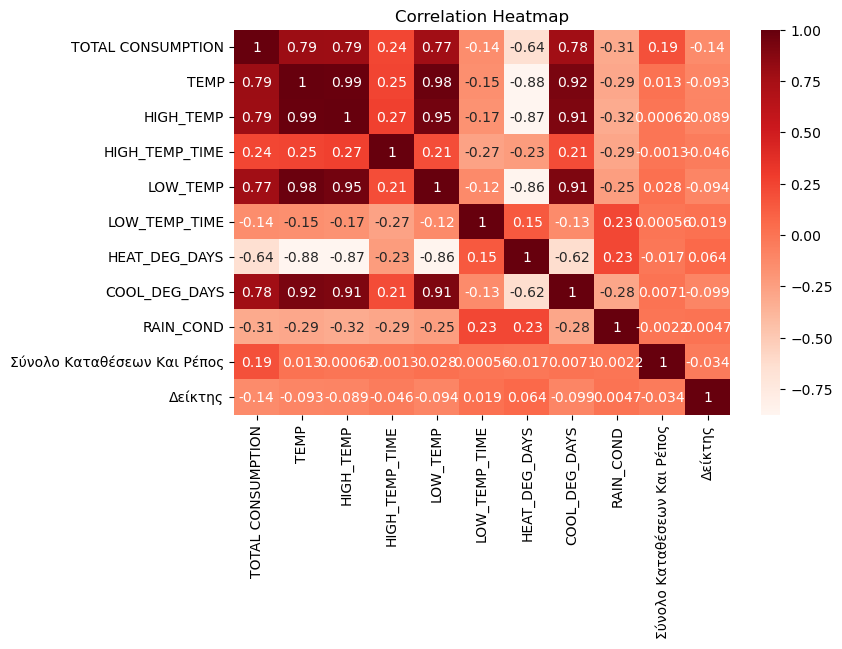

In [38]:
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_3.corr(), annot = True, cmap="Reds")

Industrial KPI has low correlation with consumption. This is because the water cost per m3 is low and the country is prosperous enough.

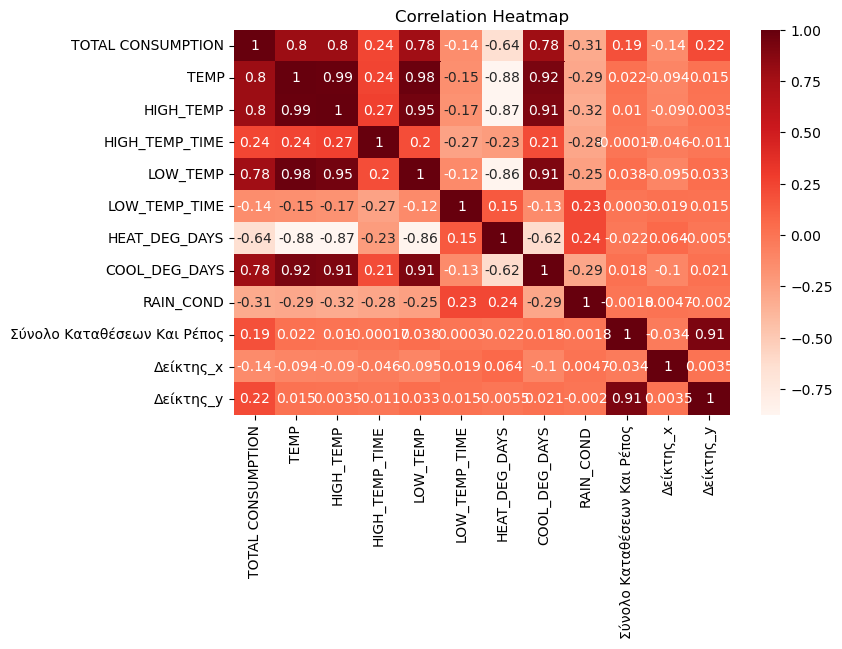

In [39]:
# Insert a new file. "KPI of retail circle" vs Year and Month* --> dianeosis.gr
retail_KPI = pd.read_csv('chart_retail_KPI.csv')
retail_KPI['Μήνας'] = retail_KPI['Mήνας'].str.split(' ')
retail_KPI['Month'] = retail_KPI['Μήνας'].str[0]
retail_KPI['Year'] = retail_KPI['Μήνας'].str[1]
retail_KPI['Year'] = retail_KPI['Year'].astype(int)
retail_KPI.drop('Μήνας',axis=1,inplace=True)
retail_KPI.replace({'Month':m},inplace=True)

DATA_3['Month'] = DATA_3['DATE'].dt.month
DATA_3['Year'] = DATA_3['DATE'].dt.year
DATA_4 = DATA_3.merge(retail_KPI, on=['Month', 'Year'], how='inner')
DATA_4.drop('Month',axis=1,inplace=True)
DATA_4.drop('Year',axis=1,inplace=True)

plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_4.corr(), annot = True, cmap="Reds")

Retail KPI has low correlation with consumption. This is because the water cost per m3 is low and the country is prosperous enough.

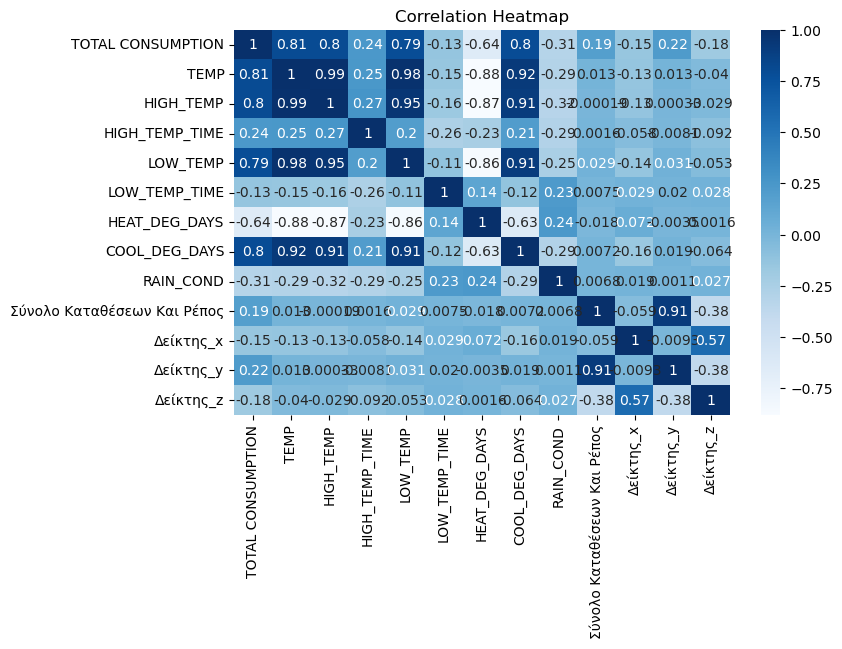

In [40]:
#chart_financial_KPI
financial_KPI = pd.read_csv('chart_financial_KPI.csv')
financial_KPI.drop('Ε.Ε-27',axis=1,inplace=True)
financial_KPI['Μήνας'] = financial_KPI['Μήνας'].str.split(' ')
financial_KPI['Month'] = financial_KPI['Μήνας'].str[0]
financial_KPI['Year'] = financial_KPI['Μήνας'].str[1]
financial_KPI['Year'] = financial_KPI['Year'].astype(int)
financial_KPI.drop('Μήνας',axis=1,inplace=True)
financial_KPI.replace({'Month':m},inplace=True)

DATA_4['Month'] = DATA_4['DATE'].dt.month
DATA_4['Year'] = DATA_4['DATE'].dt.year
DATA_5 = DATA_4.merge(financial_KPI, on=['Month', 'Year'], how='inner')
DATA_5.drop('Month',axis=1,inplace=True)
DATA_5.drop('Year',axis=1,inplace=True)
DATA_5.rename(columns={'Ελλάδα':'Δείκτης_z'},inplace=True)

plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_5.corr(), annot = True, cmap="Blues")

In [41]:
# Delete features that are not correlated, such as KPIs. 
DATA_5.drop('Δείκτης_x',axis=1,inplace=True)
DATA_5.drop('Δείκτης_y',axis=1,inplace=True)
DATA_5.drop('Δείκτης_z',axis=1,inplace=True)
DATA_5.drop('Σύνολο Καταθέσεων Και Ρέπος',axis=1,inplace=True)

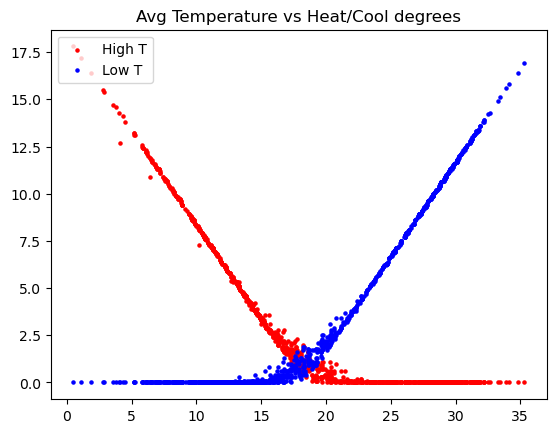

In [42]:
plt.scatter(DATA_5['TEMP'],DATA_5['HEAT_DEG_DAYS'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['TEMP'],DATA_5['COOL_DEG_DAYS'],c=('BLUE'),label='Low T',s=5)
plt.title('Avg Temperature vs Heat/Cool degrees')
plt.legend(loc=2)

In [43]:
# Delete deg_days as are highly correlated with Temp
DATA_5.drop('HEAT_DEG_DAYS',axis=1,inplace=True)
DATA_5.drop('COOL_DEG_DAYS',axis=1,inplace=True)

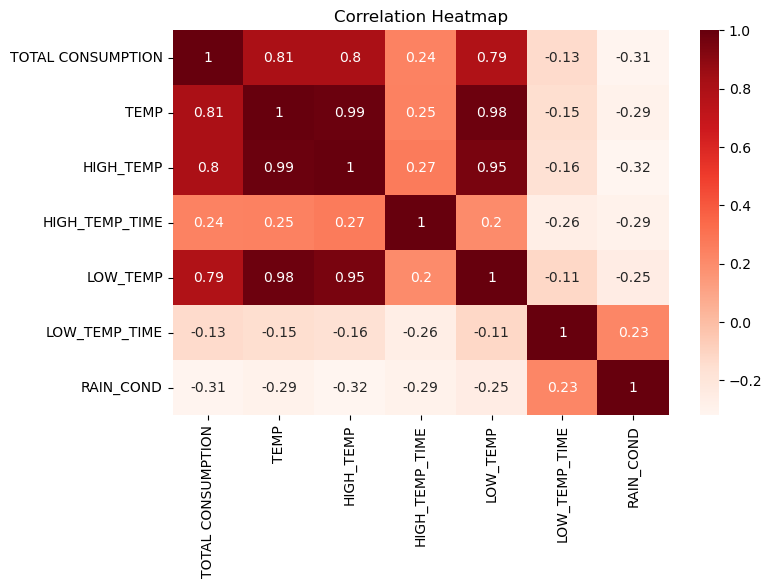

In [44]:
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_5.corr(), annot = True, cmap="Reds")

High & Low Temperature times are to be investigated for their correlation

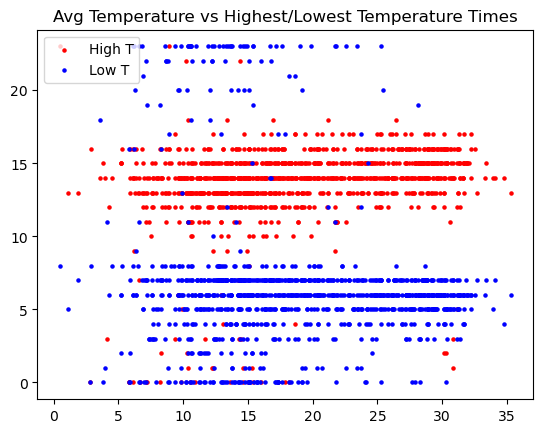

In [45]:
plt.scatter(DATA_5['TEMP'],DATA_5['HIGH_TEMP_TIME'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['TEMP'],DATA_5['LOW_TEMP_TIME'],c=('BLUE'),label='Low T',s=5)
plt.title('Avg Temperature vs Highest/Lowest Temperature Times')
plt.legend(loc=2)

Text(0.5, 0, 'CONSUMPTION')

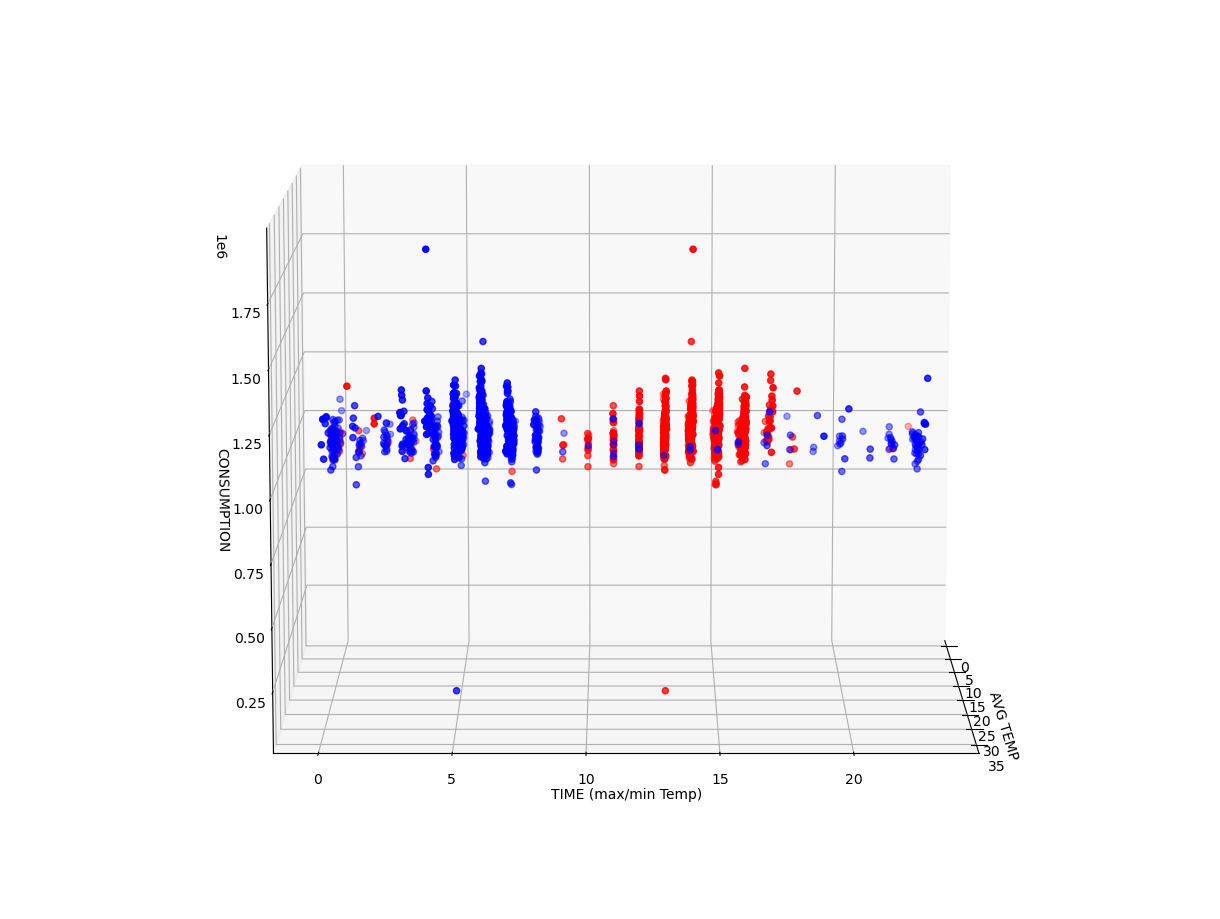

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

#for grp_name, grp_idx in df.groupby('grp').groups.items():
y = DATA_5['HIGH_TEMP_TIME']
x = DATA_5['TEMP']
z = DATA_5['TOTAL CONSUMPTION']
ax.scatter(x,y,z,color='Red')  # this way you can control color/marker/size of each group freely
#ax.scatter(*df.iloc[grp_idx, [0, 1, 2]].T.values, label=grp_name)  # if you want to do everything in one line, lol
ax.scatter(x,DATA_5['LOW_TEMP_TIME'],z,color='Blue')  # this way you can control color/marker/size of each group freely

elev, azim, roll = (10,0,0)
ax.view_init(elev, azim)

ax.set_xlabel('AVG TEMP')
ax.set_ylabel('TIME (max/min Temp)')
ax.set_zlabel('CONSUMPTION')


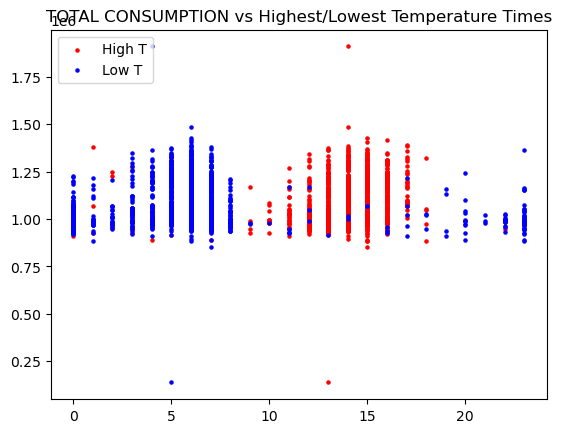

In [47]:
plt.scatter(DATA_5['HIGH_TEMP_TIME'],DATA_5['TOTAL CONSUMPTION'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['LOW_TEMP_TIME'],DATA_5['TOTAL CONSUMPTION'],c=('BLUE'),label='Low T',s=5)
plt.title('TOTAL CONSUMPTION vs Highest/Lowest Temperature Times')
plt.legend(loc=2)

No safe conclusion can be made as for the time of highst and lowest temperature time. Consumption seems stable. Thus, we delete these two features

In [48]:
DATA_5.drop('HIGH_TEMP_TIME',axis=1,inplace=True)
DATA_5.drop('LOW_TEMP_TIME',axis=1,inplace=True)

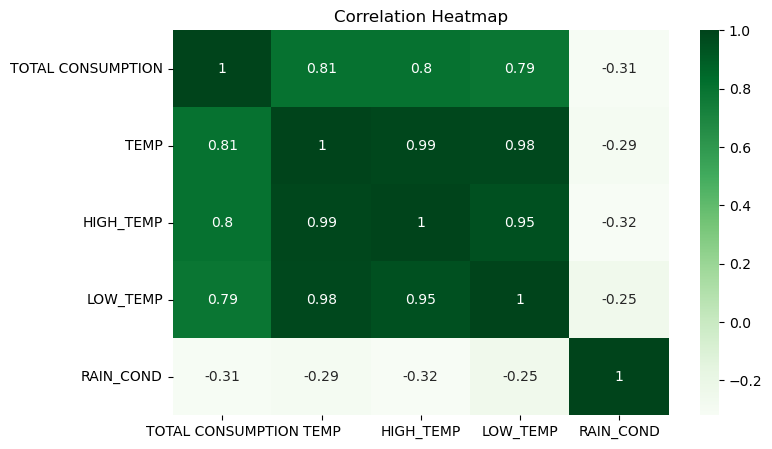

In [49]:
plt.figure(figsize = (8,5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(DATA_5.corr(), annot = True, cmap="Greens")

In [50]:
DATA_5['Temp_Dif'] = DATA_5['HIGH_TEMP'] - DATA_5['LOW_TEMP']

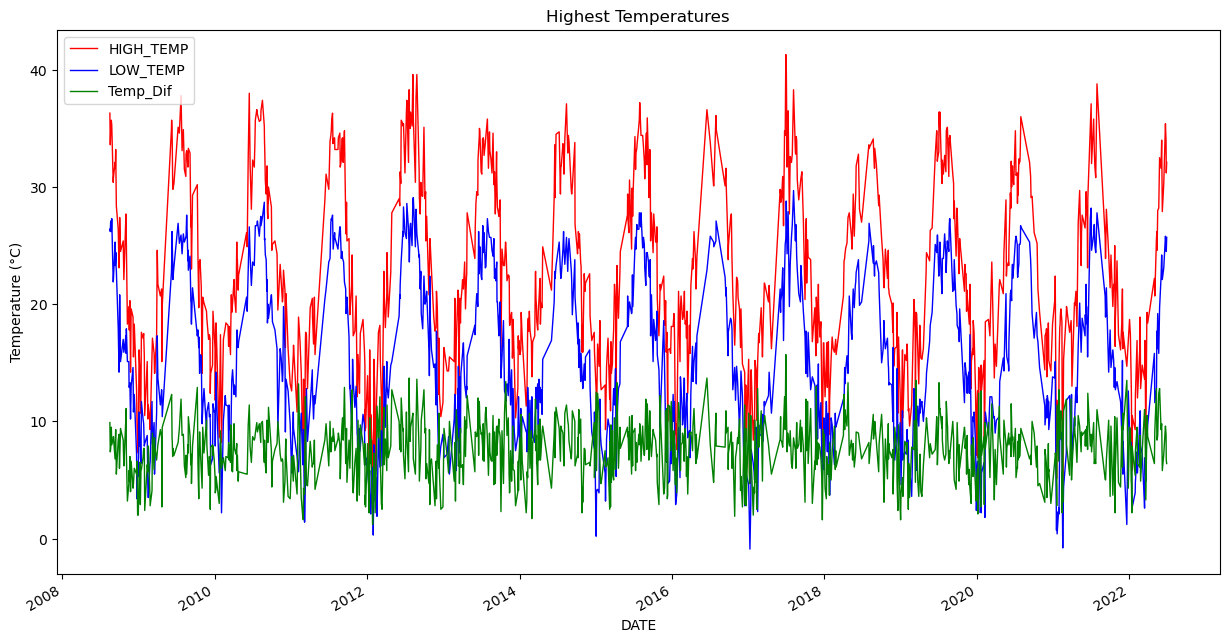

In [51]:
DATA_5.plot(x='DATE',y=['HIGH_TEMP','LOW_TEMP','Temp_Dif'],
           kind='line',
           figsize=(15,8),
           title='Highest Temperatures',
           ylabel='Temperature (°C)',
           color=['RED','BLUE','GREEN'],
            linewidth=1,
            linestyle='solid'
           )

In [52]:
DATA_5 = DATA_5[(DATA_5['TOTAL CONSUMPTION'] < DATA_5['TOTAL CONSUMPTION'].quantile(0.99)) & (DATA_5['TOTAL CONSUMPTION'] > DATA_5['TOTAL CONSUMPTION'].quantile(0.01))]

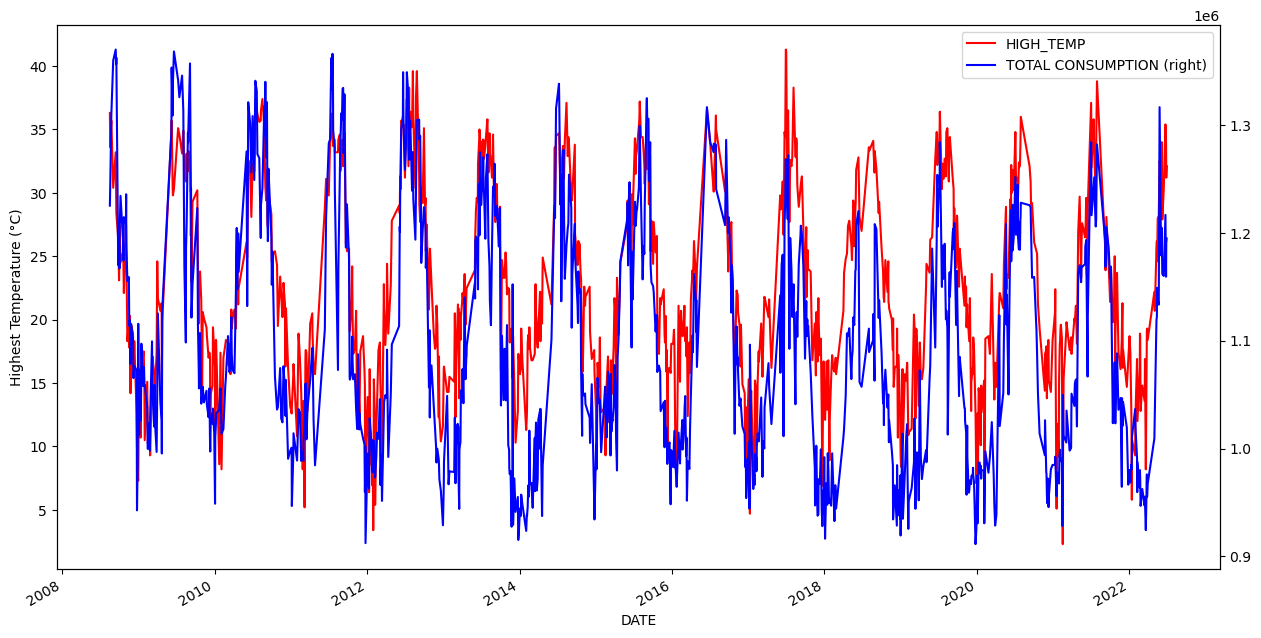

In [53]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_5.plot(x='DATE',
    use_index=True, 
    kind='line',
    y='HIGH_TEMP',
    ylabel='Highest Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_5.plot(x='DATE',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

(700000.0, 1500000.0)

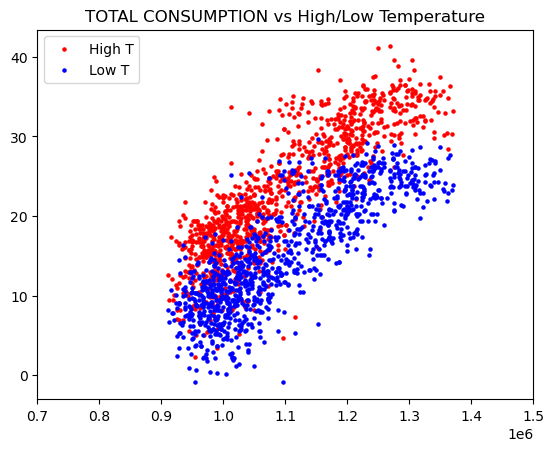

In [54]:
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['HIGH_TEMP'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['LOW_TEMP'],c=('BLUE'),label='Low T',s=5)
plt.title('TOTAL CONSUMPTION vs High/Low Temperature')
plt.legend(loc=2)
plt.xlim(0.7*10**6 , 1.5*10**6)

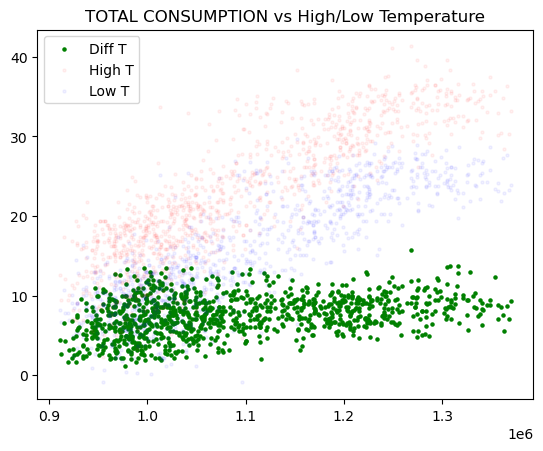

In [55]:
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['Temp_Dif'],c=('GREEN'),label='Diff T',s=5)
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['HIGH_TEMP'],c=('RED'),label='High T',s=5,alpha=0.05)
plt.scatter(DATA_5['TOTAL CONSUMPTION'],DATA_5['LOW_TEMP'],c=('BLUE'),label='Low T',s=5,alpha=0.05)
plt.title('TOTAL CONSUMPTION vs High/Low Temperature')
plt.legend(loc=2)

(700000.0, 1500000.0)

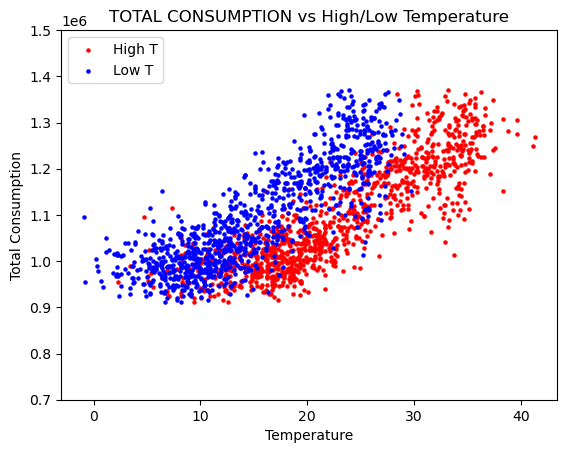

In [56]:
plt.scatter(DATA_5['HIGH_TEMP'],DATA_5['TOTAL CONSUMPTION'],c=('RED'),label='High T',s=5)
plt.scatter(DATA_5['LOW_TEMP'],DATA_5['TOTAL CONSUMPTION'],c=('BLUE'),label='Low T',s=5)
plt.title('TOTAL CONSUMPTION vs High/Low Temperature')
plt.legend(loc=2)
plt.ylabel('Total Consumption')
plt.xlabel('Temperature')
plt.ylim(0.7*10**6 , 1.5*10**6)

In [57]:
DATA_6 = DATA_5

# Create a Model 

In [58]:
data = []
DATA = []
DATA_2 = []
DATA_3 = []
DATA_4 = []

In [59]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [60]:
DATA_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 1065
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DATE               1044 non-null   datetime64[ns]
 1   TOTAL CONSUMPTION  1044 non-null   float64       
 2   TEMP               1044 non-null   float64       
 3   HIGH_TEMP          1044 non-null   float64       
 4   LOW_TEMP           1044 non-null   float64       
 5   DIR                1044 non-null   object        
 6   RAIN_COND          1044 non-null   int64         
 7   Mήνας              1044 non-null   object        
 8   Temp_Dif           1044 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 81.6+ KB


In [61]:
DATA_5.drop('DATE',axis=1,inplace=True)
DATA_5.drop('DIR',axis=1,inplace=True)
DATA_5.drop('Mήνας',axis=1,inplace=True)
DATA_5.drop('TEMP',axis=1,inplace=True)


C:\Users\PEROULIS\AppData\Local\Temp\ipykernel_5732\85930298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA_5.drop('DATE',axis=1,inplace=True)
C:\Users\PEROULIS\AppData\Local\Temp\ipykernel_5732\85930298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA_5.drop('DIR',axis=1,inplace=True)
C:\Users\PEROULIS\AppData\Local\Temp\ipykernel_5732\85930298.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATA_5.drop('Mήνας',a

In [62]:
model = LinearRegression()

In [63]:
DATA_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 1065
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TOTAL CONSUMPTION  1044 non-null   float64
 1   HIGH_TEMP          1044 non-null   float64
 2   LOW_TEMP           1044 non-null   float64
 3   RAIN_COND          1044 non-null   int64  
 4   Temp_Dif           1044 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 48.9 KB


In [64]:
#DATA_5.drop('Temp_Dif',axis=1,inplace=True)

In [65]:
X = DATA_5.drop('TOTAL CONSUMPTION',axis=1)
y = DATA_5['TOTAL CONSUMPTION']

In [66]:
# Split Dataset into training and test


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 0)

In [67]:
#Fit Model 

model.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred = model.predict(X_test)

# See Results of the Models

In [69]:
#print(model.coef_)
print(model.intercept_)
print(r2_score(y_test, y_pred))

856127.3834511614
0.7478362082128027


In [70]:
print("Linear Regression r2 score is: %f" %r2_score(y_test,y_pred))

Linear Regression r2 score is: 0.747836


In [71]:
mse = np.mean((np.array(y_test) - np.array(y_pred)) ** 2)
rmse = np.sqrt(mse)
print("Linear Regression RMSE is: %f" %rmse)

Linear Regression RMSE is: 56712.602817


Text(0.5, 1.0, 'Predictions Model: Linear Regression')

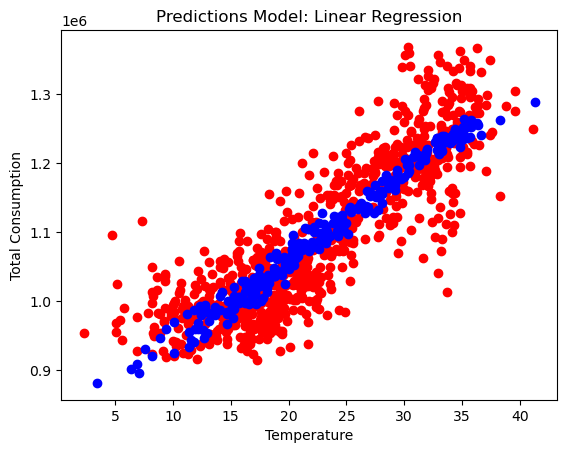

In [72]:
plt.scatter(X_train.HIGH_TEMP,y_train, color= 'red')
plt.scatter(X_test.HIGH_TEMP, model.predict(X_test), color= 'blue')
plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Model: Linear Regression')
####plt.plot(X_train.TEMP, model.predict(X_train), color= 'green')

In [73]:
logreg = LogisticRegression(max_iter= 10e5)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

Text(0.5, 1.0, 'Predictions Model: Logistic Regression')

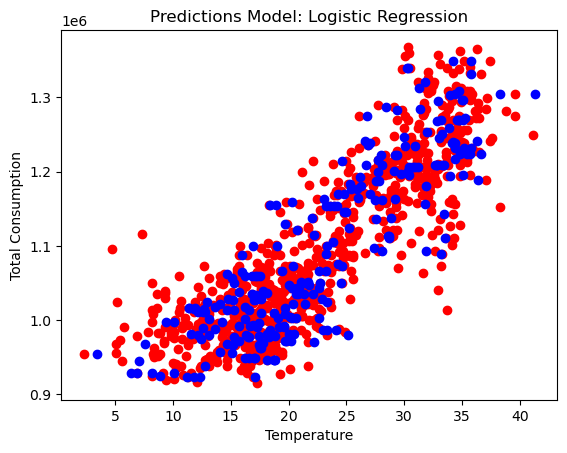

In [74]:
plt.scatter(X_train.HIGH_TEMP,y_train, color= 'red')
plt.scatter(X_test.HIGH_TEMP, y_pred_log, color= 'blue')
plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Model: Logistic Regression')

In [75]:
print("Logistic Regression r2 score is: %f" %r2_score(y_test,y_pred_log))

Logistic Regression r2 score is: 0.554658


In [76]:
model_3 = RandomForestClassifier()
model_3.fit(X_train, y_train)
y_pred_random = model_3.predict(X_test)

Text(0.5, 1.0, 'Predictions Model: Random Forest')

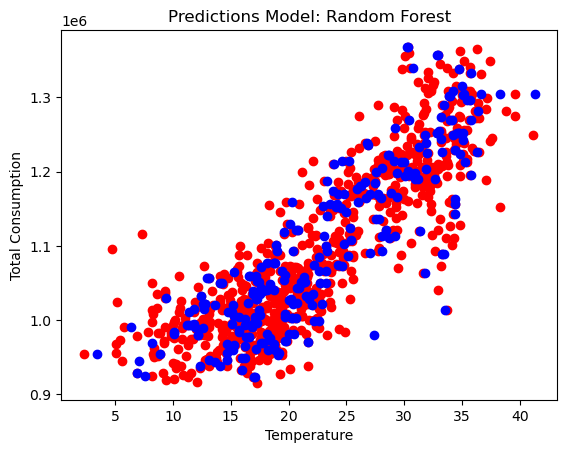

In [77]:
plt.scatter(X_train.HIGH_TEMP,y_train, color= 'red')
plt.scatter(X_test.HIGH_TEMP, y_pred_random, color= 'blue')
plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Model: Random Forest')

In [78]:
print("Random Forest r2 score is: %f" %r2_score(y_test,y_pred_random))

Random Forest r2 score is: 0.598521


# Example of the Results

In [79]:
X_test.columns

Index(['HIGH_TEMP', 'LOW_TEMP', 'RAIN_COND', 'Temp_Dif'], dtype='object')

Real Consumption: 925150
Linear Regression Consumption: 1007676
Logistic Regression Consumption: 932671
Random Forest Consumption: 1017855

Linear: [91.07964141]%
Logistic: [99.18705075]%
Random Forest: [89.97946279]%


E:\Program Files\bootcamp\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
E:\Program Files\bootcamp\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
E:\Program Files\bootcamp\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Predictions Models')

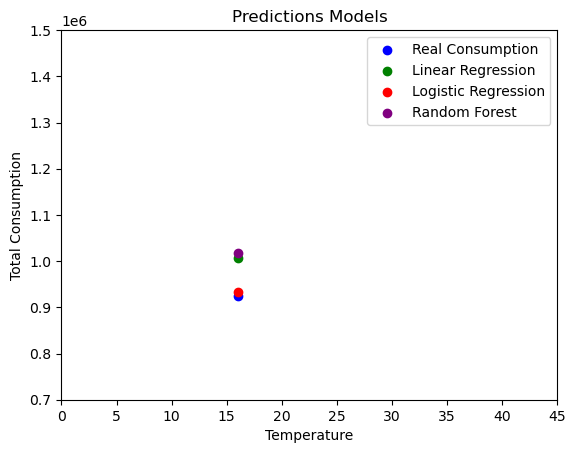

In [80]:
Year_ = 2023
Month_ = 1
Day_ = 21

high_temperature = 16
low_temperature = 7
dif_temperature = high_temperature - low_temperature
#avg_temperature = 0.7*high_temperature + 0.3*low_temperature
raining = 0


new_raw = [[high_temperature,low_temperature,raining,dif_temperature]]
try:
    #new_raw = [[avg_temperature,high_temperature,low_temperature,raining,dif_temperature]]
    pr = data.loc[data.DATE.dt.year == Year_].loc[data.DATE.dt.month == Month_].loc[data.DATE.dt.day == Day_]
    linear_row_predicition = model.predict(pd.DataFrame(new_raw))
    logistic_row_prediction = logreg.predict(pd.DataFrame(new_raw))
    random_row_prediction = model_3.predict(pd.DataFrame(new_raw))


    plt.scatter(new_raw[0][0], pr['TOTAL CONSUMPTION'], color= 'blue')
    plt.scatter(new_raw[0][0], linear_row_predicition, color= 'green')
    plt.scatter(new_raw[0][0], logistic_row_prediction, color= 'red')
    plt.scatter(new_raw[0][0], random_row_prediction, color= 'purple')

    plt.legend(['Real Consumption','Linear Regression','Logistic Regression','Random Forest'])
    EYDAP_CONSUMPTION = pr.loc[pr.index.values[0]]['TOTAL CONSUMPTION']
    reala =  pr.loc[pr.index.values[0]]['TOTAL CONSUMPTION']/1000
    linear_row_predicition = linear_row_predicition/1000
    logistic_row_prediction = logistic_row_prediction/1000
    random_row_prediction = random_row_prediction/1000
except:
    EYDAP_CONSUMPTION = 925150
    #new_raw = [[avg_temperature,high_temperature,low_temperature,raining,dif_temperature]]
    #pr = data.loc[data.DATE.dt.year == Year_].loc[data.DATE.dt.month == Month_].loc[data.DATE.dt.day == Day_]
    linear_row_predicition = model.predict(pd.DataFrame(new_raw))
    logistic_row_prediction = logreg.predict(pd.DataFrame(new_raw))
    random_row_prediction = model_3.predict(pd.DataFrame(new_raw))


    plt.scatter(new_raw[0][0], EYDAP_CONSUMPTION, color= 'blue')
    plt.scatter(new_raw[0][0], linear_row_predicition, color= 'green')
    plt.scatter(new_raw[0][0], logistic_row_prediction, color= 'red')
    plt.scatter(new_raw[0][0], random_row_prediction, color= 'purple')
    plt.legend(['Real Consumption','Linear Regression','Logistic Regression','Random Forest'])

    reala =  EYDAP_CONSUMPTION/1000
    linear_row_predicition = linear_row_predicition/1000
    logistic_row_prediction = logistic_row_prediction/1000
    random_row_prediction = random_row_prediction/1000

print('Real Consumption:',int(reala*1000))   
print('Linear Regression Consumption:',int(linear_row_predicition*1000) )
print('Logistic Regression Consumption:',int(logistic_row_prediction*1000))
print('Random Forest Consumption:',int(random_row_prediction*1000))

print('')
print(f"Linear: {(1-abs(-reala+linear_row_predicition)/(reala))*100}%")
print(f'Logistic: {(1-abs(-reala+logistic_row_prediction)/(reala))*100}%')
print(f'Random Forest: {(1-abs(-reala+random_row_prediction)/(reala))*100}%')

plt.ylim(0.7*10**6 , 1.5*10**6)
plt.xlim(0,45)

#print(EYDAP_CONSUMPTION) # Debug line

plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Models')

In [81]:
new_real_consumption = pd.read_csv('new_consumptions.csv',decimal=',')
new_real_consumption = new_real_consumption.astype(str).astype(float)*1000

In [82]:
#new_raw = [[high_temperature,low_temperature,raining,dif_temperature]]
# 09/01/23 - 09/02/23
new_pred_input = pd.read_csv('new_temperatures.csv')
new_pred_input.drop('DATE',axis=1,inplace=True)

In [83]:
# Predict MEN Output in increasing temperatures
#new_pred_input = pd.read_csv('increasing_temperatures.csv')
#new_pred_input.drop('DATE',axis=1,inplace=True)

In [84]:
Logistic_prediction = logreg.predict(pd.DataFrame(new_pred_input))
Linear_prediction = model.predict(pd.DataFrame(new_pred_input)).astype(int)

In [85]:
RandomForest_prediction = model_3.predict(pd.DataFrame(new_pred_input)).astype(int)

In [86]:
pred_df = pd.DataFrame()

In [87]:
len(Linear_prediction)

32

In [88]:
len(Logistic_prediction)

32

In [89]:
len(new_real_consumption['TOTAL CONSUMPTION'])

32

In [90]:
dic_ = {'Real':new_real_consumption['TOTAL CONSUMPTION'],
        'Linear':Linear_prediction,
        'Logistic':Logistic_prediction,
        'RandomForest':RandomForest_prediction
       }
pred_df = pd.DataFrame(dic_)

Text(0.5, 1.0, 'Predictions Models')

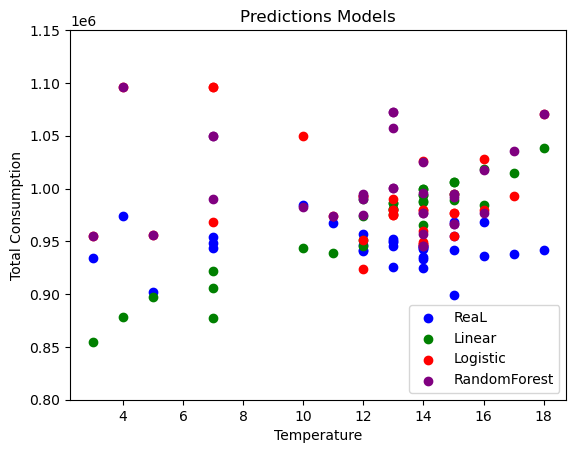

In [91]:
plt.scatter(new_pred_input.HIGH_TEMP,y=new_real_consumption, color= 'blue')
plt.scatter(new_pred_input.HIGH_TEMP, Linear_prediction, color= 'green')
plt.scatter(new_pred_input.HIGH_TEMP, Logistic_prediction, color= 'red')
plt.scatter(new_pred_input.HIGH_TEMP, RandomForest_prediction, color= 'purple')

plt.ylim(0.8*10**6 , 1.15*10**6)
plt.legend(['ReaL','Linear','Logistic','RandomForest'])

#plt.legend(['Final Model'])

plt.xlabel('Temperature')
plt.ylabel('Total Consumption')
plt.title('Predictions Models')

In [92]:
to_Analysis = pd.DataFrame()
to_Analysis['Temp'] = new_pred_input.HIGH_TEMP
to_Analysis['Consumption_Prediction'] = RandomForest_prediction
to_Analysis.to_csv('Further_Analysis.csv')

Text(0.5, 1.0, 'Predictions Models')

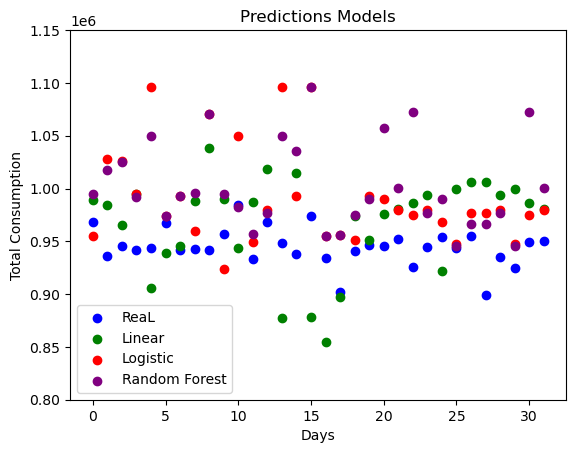

In [93]:
plt.scatter(new_real_consumption.index,y=new_real_consumption, color= 'blue')
plt.scatter(new_real_consumption.index, Linear_prediction, color= 'green')
plt.scatter(new_real_consumption.index, Logistic_prediction, color= 'red')
plt.scatter(new_real_consumption.index, RandomForest_prediction, color= 'purple')

plt.ylim(0.8*10**6 , 1.15*10**6)
plt.legend(['ReaL','Linear','Logistic','Random Forest'])

plt.xlabel('Days')
plt.ylabel('Total Consumption')
plt.title('Predictions Models')

In [94]:
pred_df['Diff_Linear'] = (abs(pred_df['Real']-pred_df['Linear'])/pred_df['Real'])*100
pred_df['Diff_Logistic'] = (abs(pred_df['Real']-pred_df['Logistic'])/pred_df['Real'])*100
pred_df['Diff_Random'] = (abs(pred_df['Real']-pred_df['RandomForest'])/pred_df['Real'])*100

In [95]:
#pred_df

In [96]:
pred_df['Rain'] = new_pred_input['RAIN_COND']*1

Linear mean error:5.01531624837518%
Logistic mean error:5.213139500394339%
RandomForest mean error:6.031648525951366%


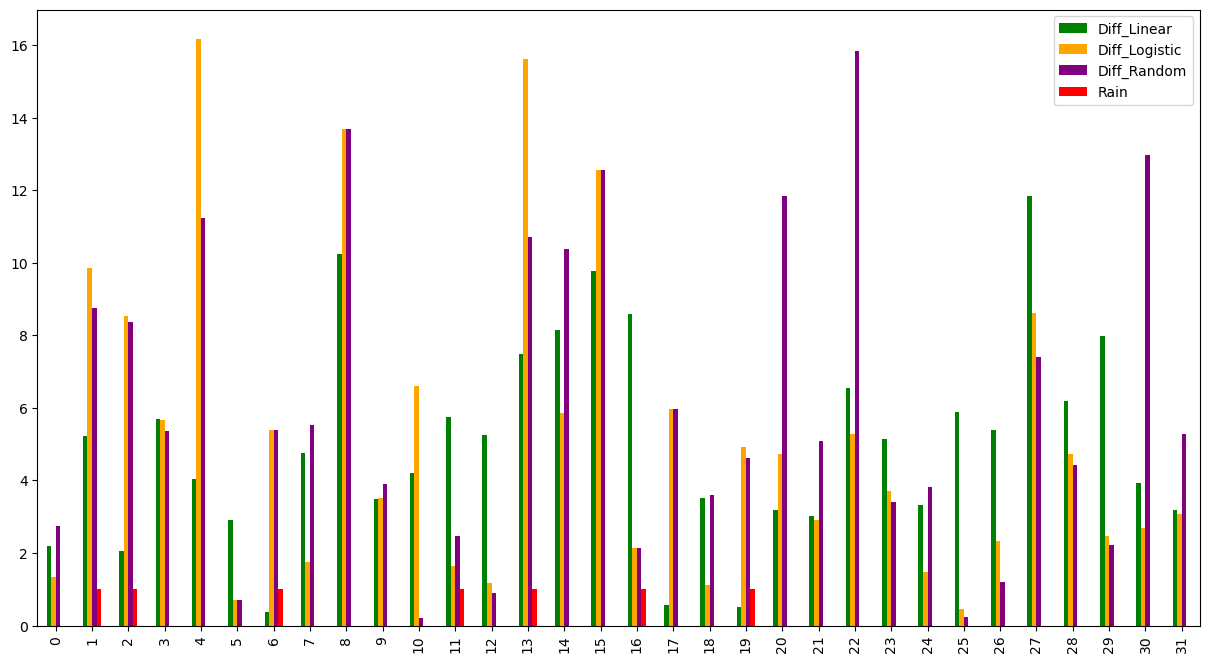

In [97]:
try:
    pred_df.drop('Real',axis=1,inplace=True)
    pred_df.drop('Linear',axis=1,inplace=True)
    pred_df.drop('Logistic',axis=1,inplace=True)
    pred_df.drop('RandomForest',axis=1,inplace=True)
except:
    pass
pred_df.plot(kind='bar',figsize=(15,8),color=['GREEN','ORANGE','PURPLE','RED'])

print(f'Linear mean error:{pred_df.Diff_Linear.mean()}%')
print(f'Logistic mean error:{pred_df.Diff_Logistic.mean()}%')
print(f'RandomForest mean error:{pred_df.Diff_Random.mean()}%')


# Group By Dates - DATA_6

In [98]:
#DATA_6.drop(['Mήνας'],axis=1,inplace=True)
#DATA_6.drop(['DIR'],axis=1,inplace=True)
#DATA_6.info()

In [99]:
DATA_6 = pd.DataFrame()

In [100]:
DATA_6 = data.copy()

In [101]:
DATA_6 = np.where(DATA_6.DATE.dt.year < 2023)

AttributeError: 'list' object has no attribute 'DATE'

In [ ]:
DATA_6 = DATA_6.loc[DATA_6.DATE.dt.year < 2023]

In [ ]:
DATA_by_year = DATA_6.groupby(DATA_6.DATE.dt.year).mean()

In [ ]:
DATA_by_year['TOTAL CONSUMPTION'] = DATA_6['TOTAL CONSUMPTION'].groupby(DATA_6.DATE.dt.year).sum()

In [ ]:
DATA_by_month = DATA_6.groupby(DATA_6.DATE.dt.month).mean()
DATA_by_month['TOTAL CONSUMPTION'] = DATA_6['TOTAL CONSUMPTION'].groupby(DATA_6.DATE.dt.month).sum()

In [ ]:
DATA_by_year['TOTAL CONSUMPTION'] = DATA_by_year['TOTAL CONSUMPTION'].groupby(DATA_6.DATE.dt.year).sum()

In [ ]:
DATA_by_day = DATA_6.groupby(DATA_6.DATE.dt.day).mean()
DATA_by_day['TOTAL CONSUMPTION'] = DATA_6['TOTAL CONSUMPTION'].groupby(DATA_6.DATE.dt.day).sum()

In [ ]:
#DATA_by_month

In [ ]:
#DATA_by_day

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_year.plot(
    use_index=True, 
    kind='line',
    y='TEMP',
    ylabel='Average Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_year.plot(xlabel ='Year',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_month.plot(xlabel ='Month',
    use_index=True, 
    kind='line',
    y='TEMP',
    ylabel='Average Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_month.plot(xlabel ='Month',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_day.plot(
    use_index=True, 
    kind='line',
    y='TEMP',
    ylabel='Average Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_day.plot(xlabel ='Day',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_year.plot(
    use_index=True, 
    kind='line',
    y='HIGH_TEMP',
    ylabel='Highest Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_year.plot(xlabel ='Year',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_month.plot(
    use_index=True, 
    kind='line',
    y='HIGH_TEMP',
    ylabel='Highest Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_month.plot(xlabel ='Month',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
# Create the figure and axes object
fig, ax = plt.subplots()
# Plot the first x and y axes:
DATA_by_day.plot(xlabel ='Day',
    use_index=True, 
    kind='line',
    y='HIGH_TEMP',
    ylabel='Highest Temperature (°C)',
    ax=ax, 
    color='red',
    figsize=(15,8)
)
# Plot the second x and y axes. 
# By secondary_y = True a second y-axis is requested
DATA_by_day.plot(xlabel ='Day',
    use_index=True, 
    y='TOTAL CONSUMPTION', 
    ax=ax, 
    secondary_y=True, 
    color='blue'
    #ylabel='Total Consumption (m3)',

)
plt.show()

In [ ]:
type(DATA_6)